In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap

In [2]:
class TrafficSimulation:
    def __init__(self, L, density, vmax, p):
        self.L = L
        self.density = density
        self.vmax = vmax
        self.p = p
        self.state = np.zeros(L, dtype=int)
        self.velocities = np.zeros(L, dtype=int)
        self.car_indexes = np.zeros(L, dtype=int)  # Array to store car indexes

        # Initialize random positions and velocities for vehicles
        num_vehicles = int(L * density)
        positions = np.random.choice(range(L), size=num_vehicles, replace=False)
        self.state[positions] = 1
        self.velocities[positions] = np.random.randint(0, vmax + 1, size=num_vehicles)
        self.car_indexes[positions] = np.arange(num_vehicles) + 1  # Assign unique index to each car

        # Track positions of cars
        self.trajectories = {i: [pos] for i, pos in zip(self.car_indexes[positions], positions)}

    def step(self):
        # Step 1: Acceleration
        self.velocities[self.state == 1] += 1
        self.velocities[self.velocities > self.vmax] = self.vmax

        # Step 2: Slowing down due to other cars
        for i in range(self.L):
            if self.state[i] == 1:
                gap = 1
                while self.state[(i + gap) % self.L] == 0:
                    gap += 1
                self.velocities[i] = min(self.velocities[i], gap - 1)

        # Step 3: Randomization
        self.velocities[self.velocities > 0] -= np.random.random(self.L)[self.velocities > 0] < self.p

        # Step 4: Car motion
        new_state = np.zeros(self.L, dtype=int)
        new_velocities = np.zeros(self.L, dtype=int)
        new_car_indexes = np.zeros(self.L, dtype=int)
        cars_moved = 0
        for i in range(self.L):
            if self.state[i] == 1:
                new_pos = (i + self.velocities[i]) % self.L
                new_state[new_pos] = 1
                new_velocities[new_pos] = self.velocities[i]
                new_car_indexes[new_pos] = self.car_indexes[i]
                if new_pos != i:
                    cars_moved += 1
                self.trajectories[self.car_indexes[i]].append(new_pos)
        self.state = new_state
        self.velocities = new_velocities
        self.car_indexes = new_car_indexes

        return cars_moved

    def display(self):
        print(''.join('.' if x == 0 else str(x) for x in self.state))

    def space_time_plot(self, timesteps):
        time_axis = np.arange(timesteps)
        space_axis = np.arange(self.L)
        plt.figure(figsize=(10, 6))
        for t in range(timesteps):
            active_cars = np.where(self.state == 1)[0]
            colors = plt.cm.rainbow(np.linspace(0, 1, len(active_cars)))
            for i, car_index in enumerate(active_cars):
                plt.scatter(t, car_index,color='blue', marker='|')#color=colors[i], 
            self.step()
        plt.xlabel('Time')
        plt.ylabel('Space')
        plt.title('Space-Time Plot of Traffic Flow')
        plt.show()

    def space_time_plot_tr(self, timesteps):
        plt.figure(figsize=(10, 6))
        for t in range(timesteps):
            self.step()

        for car_index, trajectory in self.trajectories.items():
            plt.plot(range(len(trajectory)), trajectory,markersize=1,label=f'Car {car_index}') 

        plt.xlabel('Time')
        plt.ylabel('Space')
        plt.title('Space-Time Plot of Traffic Flow')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def time_speed_plot(self, timesteps):
        time_axis = np.arange(timesteps)
        space_axis = np.arange(self.L)
        plt.figure(figsize=(10, 6))
        for t in range(timesteps):
            # Filter out sites with velocity 0
            non_zero_indices = np.nonzero(self.velocities)
            plt.scatter([t] * len(non_zero_indices[0]), non_zero_indices[0], c=self.velocities[non_zero_indices], cmap='viridis', vmin=1, vmax=self.vmax, marker='.')
            self.step()
        plt.colorbar(label='Velocity')
        plt.xlabel('Time')
        plt.ylabel('Space')
        plt.title('Time-Speed Plot of Traffic Flow')
        plt.show()
    def average_speed(self):
        total_speed = np.sum(self.velocities[self.state == 1])
        total_cars = np.sum(self.state)
        return total_speed / total_cars if total_cars > 0 else 0
        
    def run_simulation(self, timesteps):
        total_cars_moved = 0
        for _ in range(timesteps):
            total_cars_moved += self.step()
        return total_cars_moved / timesteps

In [3]:
# Example usage
L = 50
density = 0.2
vmax = 5
p = 0.2
sim = TrafficSimulation(L, density, vmax, p)
print("Initial state:")
sim.display()
for _ in range(10):
    sim.step()
    print("Step:")
    sim.display()


Initial state:
.........1.......1....1..1.111.............1.11...
Step:
...........1.....1......1.111.....1.........11...1
Step:
...1..........1...1......111.1.........1....1.1...
Step:
.......1.........1..1....111...1..........1..1.1..
Step:
............1......1..1..11.1.....1.........1.1.1.
Step:
.................1...1..11.1..1.......1.....1.1..1
Step:
.1..................1.1.1.1.1....1.........1.1.1..
Step:
....1...............1..1.11..1.......1......1.1..1
Step:
..1.....1............1..11.1...1..........1.1...1.
Step:
.1....1......1.........11.1..1...1.........1.1....
Step:
....1......1......1....1.1..1...1...1.......1.1...


In [8]:
# Initialize simulation
def update_plot(frame):
    ax.clear()
    sim.step()
    ax.set_xlim(-1, sim.L)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    cars = np.where(sim.state != 0)[0]
    ax.scatter(cars, np.zeros_like(cars), color='blue', marker='|', s=200)

# Parameters
length =100
density = 0.2
vmax = 5
p = 0.2
steps = 1000

# Initialize simulation
sim = TrafficSimulation(length, density, vmax, p)

# Create figure and axis
fig, ax = plt.subplots()

# Create animation
ani = animation.FuncAnimation(fig, update_plot, frames=steps, interval=50)

HTML(ani.to_jshtml())

NameError: name 'TrafficSimulation' is not defined

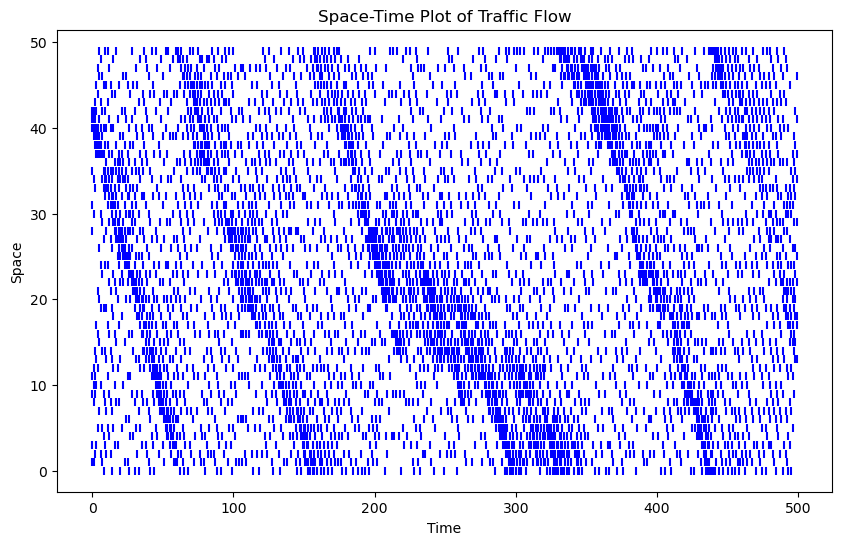

In [6]:
# Example usage
L = 50
density = 0.2
vmax = 5
p = 0.2
sim = TrafficSimulation(L, density, vmax, p)
sim.space_time_plot(500)

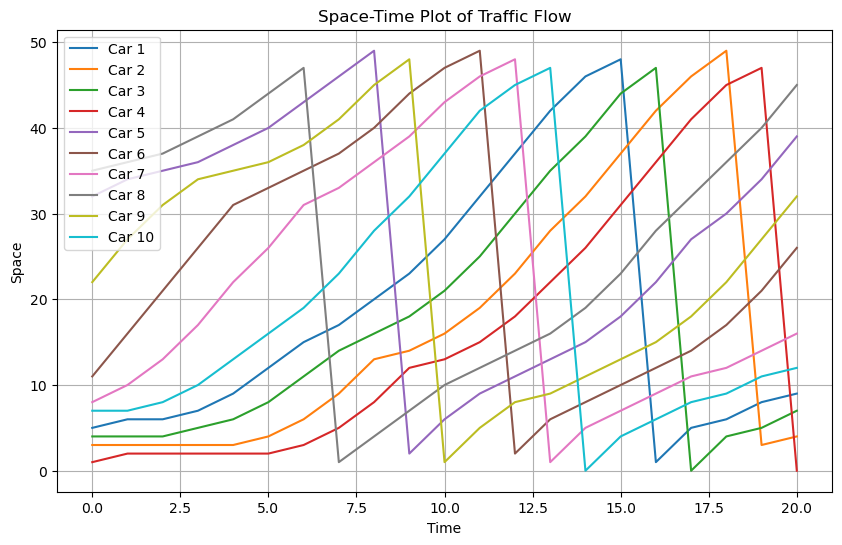

In [7]:
# Example usage
L = 50
density = 0.2
vmax = 5
p = 0.2
sim = TrafficSimulation(L, density, vmax, p)
sim.space_time_plot_tr(20)

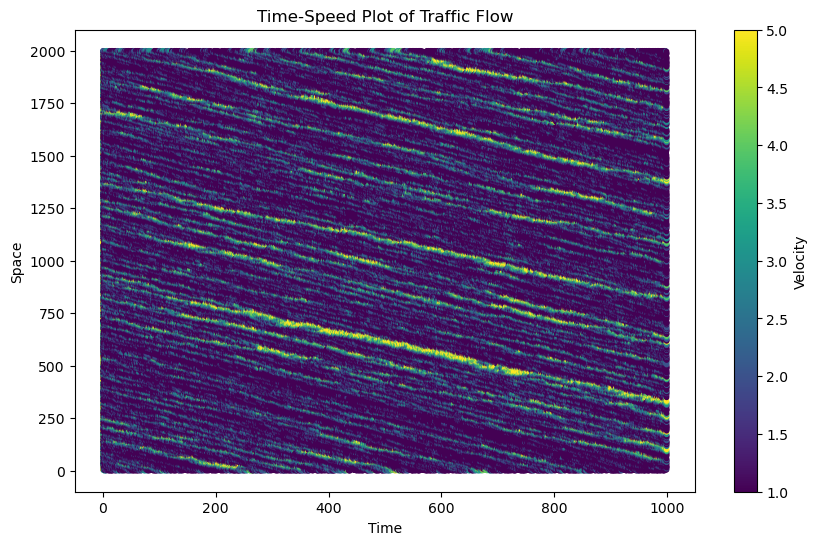

In [8]:
# Example usage
L = 2000
density = 0.5
vmax = 5
p = 0.2
sim = TrafficSimulation(L, density, vmax, p)
sim.time_speed_plot(1000)

In [9]:
def traffic_flow_vs_density(L, vmax, p, densities, short_timesteps, long_timesteps):
    avg_flow_short = []
    avg_flow_long = []
    
    for density in densities:
        # Short-term simulation
        sim_short = TrafficSimulation(L, density, vmax, p)
        flow_short = sim_short.run_simulation(short_timesteps)
        avg_flow_short.append(flow_short)
        
        # Long-term simulation
        sim_long = TrafficSimulation(L, density, vmax, p)
        flow_long = sim_long.run_simulation(long_timesteps)
        avg_flow_long.append(flow_long)
    
    return avg_flow_short, avg_flow_long

In [9]:
# Parameters
L = 1000
vmax = 5
p = 0.2
densities = np.linspace(0.05, 1.0, 10)
short_timesteps = 100
long_timesteps = 1000

# Run simulation
avg_flow_short, avg_flow_long = traffic_flow_vs_density(L, vmax, p, densities, short_timesteps, long_timesteps)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(densities, avg_flow_long, label='Long-term average (10^6 steps)', linestyle='-')
plt.scatter(densities, avg_flow_short, label='Short-term average (100 steps)', color='red')
plt.xlabel('Density (cars per site)')
plt.ylabel('Traffic Flow (cars per time step)')
plt.title('Traffic Flow vs. Density')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'traffic_flow_vs_density' is not defined

In [10]:
def fundamental_diagram(L, vmax, p, densities, T,timesteps):
    avg_flow = []
    average_speeds = []
    for density in densities:
        sim = TrafficSimulation(L, density, vmax, p)
        total_flow = sim.run_simulation(timesteps)
        avg_flow.append(total_flow)
        avg_speed = 0
        for _ in range(T):
            sim.step()
            avg_speed += sim.average_speed()
        average_speeds.append(avg_speed / T)
    return avg_flow, average_speeds

In [11]:
# Parameters
L = 1000
vmax = 5
p = 0.2
densities = np.linspace(0.01, 1.0, 10)  # Densities from 0.01 to 1.0 in 20 steps
T = 1000  # Simulation time
timesteps = 100

# Calculate average speeds
avg_flow, average_speeds = fundamental_diagram(L, vmax, p, densities, T,timesteps)

NameError: name 'TrafficSimulation' is not defined

In [12]:
# Plot fundamental diagram
plt.figure(figsize=(10, 6))
plt.plot(densities, average_speeds, 'o-')
plt.xlabel('Density (cars per site)')
plt.ylabel('Average Speed (cells per time step)')
plt.title('Fundamental Diagram of Traffic Flow')
plt.grid(True)
plt.show()

NameError: name 'average_speeds' is not defined

<Figure size 1000x600 with 0 Axes>

In [13]:
# Plot fundamental diagram
plt.figure(figsize=(10, 6))
plt.plot(avg_flow, average_speeds, 'o-')
plt.xlabel('Flow (cars per time step)')
plt.ylabel('Average Speed (cells per time step)')
plt.title('Fundamental Diagram of Traffic Flow')
plt.grid(True)
plt.show()

NameError: name 'avg_flow' is not defined

<Figure size 1000x600 with 0 Axes>